### Imports

In [32]:
import pandas as pd
import numpy as np
import gdown
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.impute import SimpleImputer
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

### Download and read csv

In [33]:
url = "https://drive.google.com/u/0/uc?id=1VUn2WKkKeRXwH02K9bqH98KjPxrUmgXh&export=download"
filename = "HousingData.csv"
gdown.download(url, filename, quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?id=1VUn2WKkKeRXwH02K9bqH98KjPxrUmgXh&export=download
To: /home/vasilis/projects/ai2-1st-assignement/HousingData.csv
100%|██████████| 1.60M/1.60M [00:00<00:00, 3.62MB/s]


'HousingData.csv'

In [34]:
data = pd.read_csv("HousingData.csv")

### Remove empty entries

In [ ]:
data.dropna(inplace = True)

### Prepare X and y
- y is Median House Value
- X is all the other columns

In [35]:
y = data[['Median House Value']]
X = data[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']]

### Feature Scaling
Convert X data in order to make the numerical attributes have the similar scales

In [36]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, random_state=42)

### Stochastic Gradient Descent

In [38]:
reg =  SGDRegressor(loss='huber', max_iter=1000)

### Cross Validation Score

In [39]:
%%time

score = cross_val_score(reg , X_train, y_train, scoring = "neg_mean_squared_error", cv = 10, n_jobs=4)

CPU times: user 43.5 ms, sys: 33.1 ms, total: 76.6 ms
Wall time: 1.99 s


In [40]:
tree_rmse_scores = np.sqrt(-score)
tree_rmse_scores.mean()

0.7677536199911104

In [41]:
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

In [42]:
r2_score(y_test, y_pred)

0.5342444246014115

### Batch Gradient Descent

Αλλάζοντας το **learning rate** σε 0,01 δίνει λίγο καλύτερα **r2 score** (περίπου 0,53 με learning_rate=0.1, 0,59 με learning_rate=0.01)  

In [60]:
# function to compute predictions created for the current dataset
# where y = w0 + w1*x1 +...+w8*x8 
def predict(X, theta):
  return np.dot(X, theta[0:8]) + theta[8]
  
# function to compute gradient of error 
def gradient(X, y, theta): 
    h = np.dot(X, theta) 
    grad = (2/X.shape[0])*np.dot(X.transpose(), (h - y)) 
    return grad 
  
# function to compute MSE
def cost(X, y, theta): 
    h = np.dot(X, theta) 
    J = np.dot((h - y).transpose(), (h - y)) 
    J /= X.shape[0]
    return J[0] 
  
# function to perform mini-batch gradient descent
def gradientDescent(X, y, learning_rate = 0.01, steps=1000): 
    X = np.c_[ X, np.ones(X.shape[0]) ] #add a column of ones to X for the bias term
    theta = np.zeros((X.shape[1], 1)) #create inital weights w0, w1..wd
    error_list = []  
    for s in range(steps):
      theta = theta - learning_rate * gradient(X, y, theta) 
      error_list.append(cost(X, y, theta)) #useful for plotting changes when using different batch sizes
  
    return theta, error_list 

theta, errors = gradientDescent(X_train, y_train)
y_pred = predict(X_test, theta)

To **Batch Gradient Descent** παρτηρούμε πως δίνει καλύτερα score από το **Stochastic Gradient Descent** 

In [61]:
r2_score(y_test,y_pred)

0.5870693178443457

In [45]:
mean_squared_error(y_test, y_pred)

0.5537841871772231

### Mini Batch Gradient Descent

Πρόσθεσα τη συνάρτηση **create_mini_batches** που δημιουργεί κάθε φορά μία λίστα με mini batches για το training και άλλαξα το learning rate κι εδώ σε 0.01

In [46]:
# function to compute predictions created for the current dataset
# where y = w0 + w1*x1 +...+w8*x8 
def predict(X, theta):
  return np.dot(X, theta[0:8]) + theta[8]
  
# function to compute gradient of error 
def gradient(X, y, theta): 
    h = np.dot(X, theta) 
    grad = (2/X.shape[0])*np.dot(X.transpose(), (h - y)) 
    return grad 
  
# function to compute MSE
def cost(X, y, theta): 
    h = np.dot(X, theta) 
    J = np.dot((h - y).transpose(), (h - y)) 
    J /= X.shape[0]
    return J[0] 
 
def create_mini_batches(X, y, batch_size): 
    mini_batches = [] 
    data = np.hstack((X, y)) 
    np.random.shuffle(data) 
    n_minibatches = data.shape[0] // batch_size 
    i = 0
  
    for i in range(n_minibatches + 1): 
        mini_batch = data[i * batch_size:(i + 1)*batch_size, :] 
        X_mini = mini_batch[:, :-1] 
        Y_mini = mini_batch[:, -1].reshape((-1, 1)) 
        mini_batches.append((X_mini, Y_mini)) 
    if data.shape[0] % batch_size != 0: 
        mini_batch = data[i * batch_size:data.shape[0]] 
        X_mini = mini_batch[:, :-1] 
        Y_mini = mini_batch[:, -1].reshape((-1, 1)) 
        mini_batches.append((X_mini, Y_mini)) 
    return mini_batches    
  
# function to perform mini-batch gradient descent
def gradientDescent(X, y, learning_rate = 0.01, steps=1000, mini_batch_size=500): 
    X = np.c_[ X, np.ones(X.shape[0]) ] #add a column of ones to X for the bias term
    theta = np.zeros((X.shape[1], 1)) #create inital weights w0, w1..wd
    error_list = [] 
    counter = 1 
    for s in range(steps):
      mini_batches = create_mini_batches(X, y, mini_batch_size)
      for mini_batch in mini_batches:
        X_mini, y_mini = mini_batch
        theta = theta - learning_rate * gradient(X_mini, y_mini, theta) 
        error_list.append(cost(X_mini, y_mini, theta)) #useful for plotting changes when using different batch sizes
      counter+=1
    return theta, error_list 

In [47]:
theta, errors = gradientDescent(X_train, y_train)
y_pred = predict(X_test, theta)

To Mini **Batch Gradient Descent** δίνει τα καλύτερα score από τις τρεις προσεγγίσεις (**Stochastic**, **Batch**, **Mini Batch**)

In [48]:
r2_score(y_test,y_pred)

0.5946344215964778

In [49]:
plot_data = {
    'cost': errors,
    'MSE_test' : mean_squared_error(y_test, y_pred),
    'MSE_train' : mean_squared_error(y_train, predict(X_train, theta))
}

<AxesSubplot:>

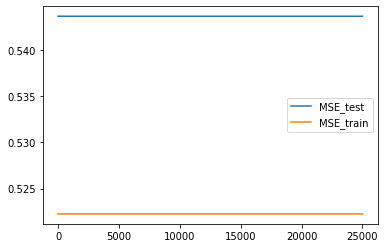

In [50]:
df = pd.DataFrame(plot_data, columns = ['cost', 'MSE_test', 'MSE_train'])
df.plot()